# Import Packages

In [1]:
# Do not modify this cell!

import jdc
# --
import numpy as np
# --
from rl_glue import RLGlue
# --
from agent import BaseAgent 
from environment import BaseEnvironment  
# --
from manager import Manager
# --
from itertools import product
# --
from tqdm import tqdm
# -- 
import pandas as pd
# -- 
import matplotlib.pyplot as plt

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 500)

# Set the maximum number of columns to display
pd.set_option('display.max_columns', 500)

In [2]:
print("read in data")
df_test = pd.read_csv("../../Data/RL_df_test.csv")
df_test = df_test[['dim', 'anm_ida', 'mk_wgt', 'scc_max', 'hrd_ida']]
df_train = pd.read_csv("../../Data/RL_df_train.csv")
df_train = df_train[['dim', 'anm_ida', 'mk_wgt', 'scc_max', 'hrd_ida']]
herd_idx_test = df_test['hrd_ida'].unique()
print(herd_idx_test)
herd_idx_train = df_train['hrd_ida'].unique()
print(herd_idx_train)

read in data
[ 8  9 43 12 33 36  0 44  4 48 29 46 49 16 24 40  5 20 50  2  7 25 17 39
 19 14 47 27 28 35 21 18 42 23 31  6  3 10 15 26 37 32  1 51 11 41 13 22
 45 34 30 38]
[11  9 49 29 32 34 18  8  5  7 51 47 33 44 12 24 15  0 16 35 10 42  6 37
 30 26 19 20  3 13 40  4 27 28 31 41  2 23 25 36 46 22 48  1 38 45 14 43
 50 39 21 17]


# Environment

In [3]:
print("setting the environment...")
class FarmEnvironment(BaseEnvironment):
    
    # init as a health cow
    def env_init(self, env_info={}, verbose=False):

        # init verbose as printing boolean 
        self.printing = verbose
        # init state as health from start
        self.state = 0
        # init day as the first day 
        self.days = 0
        # init maximum dim 
        self.max_dim = env_info['max_dim']
        # init reward 
        self.reward = 0
        # init amount of antibiotic 
        self.antibiotic = 0 
        # init the one time useage of antibiotic 
        self.antibiotic_once = env_info['antibiotic_once']
        # init milk withhold days during treatment 
        self.milk_withhold = env_info['milk_withhold']
        # init milk withhold days for nonanti 
        self.milk_withhold_nonanti = env_info['milk_withhold_nonanti']
        # init bacteria test result 
        self.bact_test_result = 'no_result'
        
        #print("setting trasitional probabilities...")
        # prob of getting clinicial mastitis
        self.p_cm = env_info['p_cm']
        # prob of getting sub-clinicial mastitis
        self.p_scm = env_info['p_scm']
        # prob of staying healthy
        self.p_health = 1 - self.p_cm -self.p_scm
        # prob of transit from scm to cm
        self.p_scm2cm = env_info['p_scm2cm']
        # prob of transit from scm to cm
        self.p_cm2scm = env_info['p_cm2scm']
        # prob of self cure from cm 
        self.p_cm_cure = env_info['p_cm_cure']
        # prob of self cure from scm 
        self.p_scm_cure = env_info['p_scm_cure']
        # prob of having gram pos mastitis 
        self.p_gram_pos = env_info['p_gram_pos']
        # prob of having gram neg mastitis 
        self.p_gram_neg = env_info['p_gram_neg']
        # prob of cure from antibiotic treatment 
        self.p_anti_cure = env_info['p_anti_cure']
        # prob of cure from non-antibiotic treatment 
        self.p_nonanti_cure = env_info['p_nonanti_cure']
  
        #print("setting rewards...")
        # reward from milk out of healthy cow
        self.r_health = env_info['r_health']
        # reward from milk out of scm cow
        self.r_scm = env_info['r_scm']
        # reward(cost) of scc test
        self.r_scc_test = env_info['r_scc_test']
        # reward(cost) of bacteria test
        self.r_bact_test = env_info['r_bact_test']
        # reward(cost) of treating mastitis
        self.r_treat = env_info['r_treat']
        # reward(cost) of treating without antibiotic 
        self.r_nonanti_treat = env_info['r_nonanti_treat']
        
    def env_start(self):
        """The first method called when the episode starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """
        reward = 0
        state == 0
        termination = False
        self.reward_state_term = (reward, state, termination)

        return self.reward_state_term[1]

    # do one step
    """
    func: 
        a step (response) from the environment 
        the cow produce reward by reward_milk
        and become scm/cm by scc_index
        under scm, reward is 0.8*reward_milk
    args: 
        action: action from the agent
        reward_milk: (float) reward of milk from the mk_wgt
        scc_index: (int: 0, 1, 2) indicating scm or cm
    return: 
        change self.state and return
        self.reward_state_term (self.reward, self.state, self.terminal)
    """
    def env_step(self, action, reward_milk, scc_index):
        
        # change in day
        self.days += 1 
        # terminate if days exceeds maximum dim
        if self.days > self.max_dim: 
            self.terminal = True
        else: 
            self.terminal = False
        
        ## 1. if in state health
        if self.state == 0:
            ## 1.1. update reward 
            self.reward += reward_milk
            
            ## 1.2. transit to other state
            # might change to scm 
            if scc_index == 1: 
                self.state = 1
                
            # might change to cm
            elif scc_index == 2: 
                self.state = 2
                
            # else stay healthy 
            else: 
                self.state = 0
            
        ## 2. if in state scm
        elif self.state == 1 or self.state == 3: 
            ## 2.1. update reward 
            self.reward += int(0.8*reward_milk)
            
            ## 2.2. transit to other states
            # might change to health 
            if np.random.uniform(0, 1, 1) < self.p_scm_cure: 
                self.state = 0
                
            # might change to cm
            elif np.random.uniform(0, 1, 1) < self.p_scm2cm: 
                self.state = 2
                
        ## 3. if in state cm
        else: 
            
            # 3.1. no reward for cm 
            
            # 3.2. transit to other states
            # might change to health 
            if np.random.uniform(0, 1, 1) < self.p_cm_cure: 
                self.state = 0
                
            # might change to scm
            elif np.random.uniform(0, 1, 1) < self.p_cm2scm: 
                self.state = 1
            # else stay cm 
            else: 
                self.state = 2
        
        ## 4. if taking action: test 
        if action == 1: 
            
            # first add the cost of scc testing
            self.reward -= self.r_scc_test
            
            # then if the current state is scm, change to scm_find
            if self.state == 1:
                self.state = 3
        
        ## 5. if taking action: bact_test
        if action == 3:
            
            # first add the cost of bact_test
            self.reward -= self.r_bact_test
            
            # give self.bact_test_result 
            if np.random.uniform(0, 1, 1) < self.p_gram_pos:
                # test it to be 'gram_pos'
                self.state = 4
            else: 
                # test it to be 'gram_neg'
                self.state = 5
                
        ## 6. if taking action: treat 
        if action == 2: 
            
            # first add the cost of treatment 
            self.reward -= self.r_treat
            
            # add the use of antibiotic 
            self.antibiotic += self.antibiotic_once
            
            # update the days required by the treatment
            self.days += self.milk_withhold 
            
            # the state might change to health by treatment
            if np.random.uniform(0, 1, 1) < self.p_anti_cure: 
                self.state = 0
                
        ## 7. if taking action: nonanti_treat 
        if action == 4: 
            
            # add the cost of treatment 
            self.reward -= self.r_nonanti_treat
            
            # update the days required by the treatment 
            self.days += self.milk_withhold_nonanti
            
            # the state might change to health by treatment 
            if np.random.uniform(0, 1, 1) < self.p_nonanti_cure: 
                self.state = 0           

        # put reward, state, terminal to a set for return
        self.reward_state_term = (self.reward, self.state, self.terminal)
        
        if self.printing:
            print("reward, state, terminal: ", self.reward, states_ls[self.state], self.terminal)
            print("days: ", self.days)
        return self.reward_state_term
        
    # clean up message
    def env_cleanup(self, reward):
        # reset the states to health 
        self.state = 0
        # reset day 
        self.days = 0
        # reset reward 
        self.reward = 0 
        # reset terminal 
        self.terminal = False
        # reset antibiotic 
        self.antibiotic = 0
        # reset bacteria testing result 
        env.bact_test_result = 'no_result'
        
        if self.printing:
            print("clean up agent and reset days, reward: ", self.days, self.reward)
            print("================================================================")

setting the environment...


In [12]:
env_info_interval = {
            'max_dim':[300, 350, 400],
            #'max_dim':[30],
            'milk_withhold':[15, 20, 25],
            'milk_withhold_nonanti': [1, 2, 3],
            'antibiotic_once':[1, 1, 1],
            'p_cm':[0.0002, 0.0004, 0.0006], 
            'p_scm':[0.002, 0.004, 0.006], 
            'p_scm2cm':[0.1, 0.2, 0.4], 
            'p_cm2scm':[0, 0, 0], 
            'p_cm_cure':[0.0025, 0.00375, 0.005],
            'p_scm_cure':[0.0025, 0.005, 0.010],
            'p_gram_pos':[0.5, 0.7, 0.9],
            'p_gram_neg':[0.1, 0.3, 0.5],
            'p_anti_cure':[0.85, 0.9, 0.95],
            'p_nonanti_cure':[0.7, 0.8, 0.9],
            'r_health':[30, 35, 40], 
            'r_scm':[10, 15, 20],
            'r_scc_test':[1, 2, 3],
            'r_bact_test':[5, 10, 15],
            'r_treat':[200, 400, 600],
            'r_nonanti_treat':[50, 100, 200]
            }


"""
env_info_interval = {
            #'max_dim':[300, 350, 400],
            'max_dim':[20], # this is for de-bug !!!!!!!!!!!!!!!!!!!!!!!!!!
            'milk_withhold':[15, 20, 25],
            'milk_withhold_nonanti': [1, 2, 3],
            'antibiotic_once':[1, 1, 1],
            #'p_cm':[0, 0, 0], 
            'p_cm':[0.6], # this is for de-bug !!!!!!!!!!!!!!!!!!!!!!!!!!
            'p_scm':[0.8], 
            'p_scm2cm':[0.8], 
            'p_cm2scm':[0, 0, 0], 
            'p_cm_cure':[0.0025, 0.00375, 0.005],
            'p_scm_cure':[0.0025, 0.005, 0.010],
            'p_gram_pos':[0.5, 0.7, 0.9],
            'p_gram_neg':[0.1, 0.3, 0.5],
            'p_anti_cure':[0.9],
            'p_nonanti_cure':[0.8],
            'r_health':[20, 22.5, 25], 
            'r_scm':[15, 17.5, 20],
            'r_scc_test':[1, 2.5, 5],
            'r_bact_test':[10, 15, 20],
            'r_treat':[100, 125, 150],
            'r_nonanti_treat':[50, 75, 100]
            }
"""
print()

In [13]:

# take the middle value to test the 3 methods below 
key_ls = [i for i in env_info_interval]
value_ls = [env_info_interval[i] for i in env_info_interval]
env_info = {key:round(sum(value)/len(value), 5) for key, value in zip (key_ls, value_ls)}

"""using env_init to init envrionment"""
states_ls = ['health', 'scm', 'cm', 'scm_find', 'gram_pos', 'gram_neg']
actions_ls = ['nothing', 'test', 'treat', 'bact_test', 'nonanti_treat']

print("the string list of actions_ls and states_ls were used as index, for example q[row, col] is q[state_idx, action_idx]")
print("as a reminder...")
print("states: ")
for i in range(len(states_ls)): 
    print("index: ", i, "state: ", states_ls[i])
print("actions: ")
for i in range(len(actions_ls)): 
    print("index: ", i, "action: ", actions_ls[i])

the string list of actions_ls and states_ls were used as index, for example q[row, col] is q[state_idx, action_idx]
as a reminder...
states: 
index:  0 state:  health
index:  1 state:  scm
index:  2 state:  cm
index:  3 state:  scm_find
index:  4 state:  gram_pos
index:  5 state:  gram_neg
actions: 
index:  0 action:  nothing
index:  1 action:  test
index:  2 action:  treat
index:  3 action:  bact_test
index:  4 action:  nonanti_treat


here we print the environmental infomation


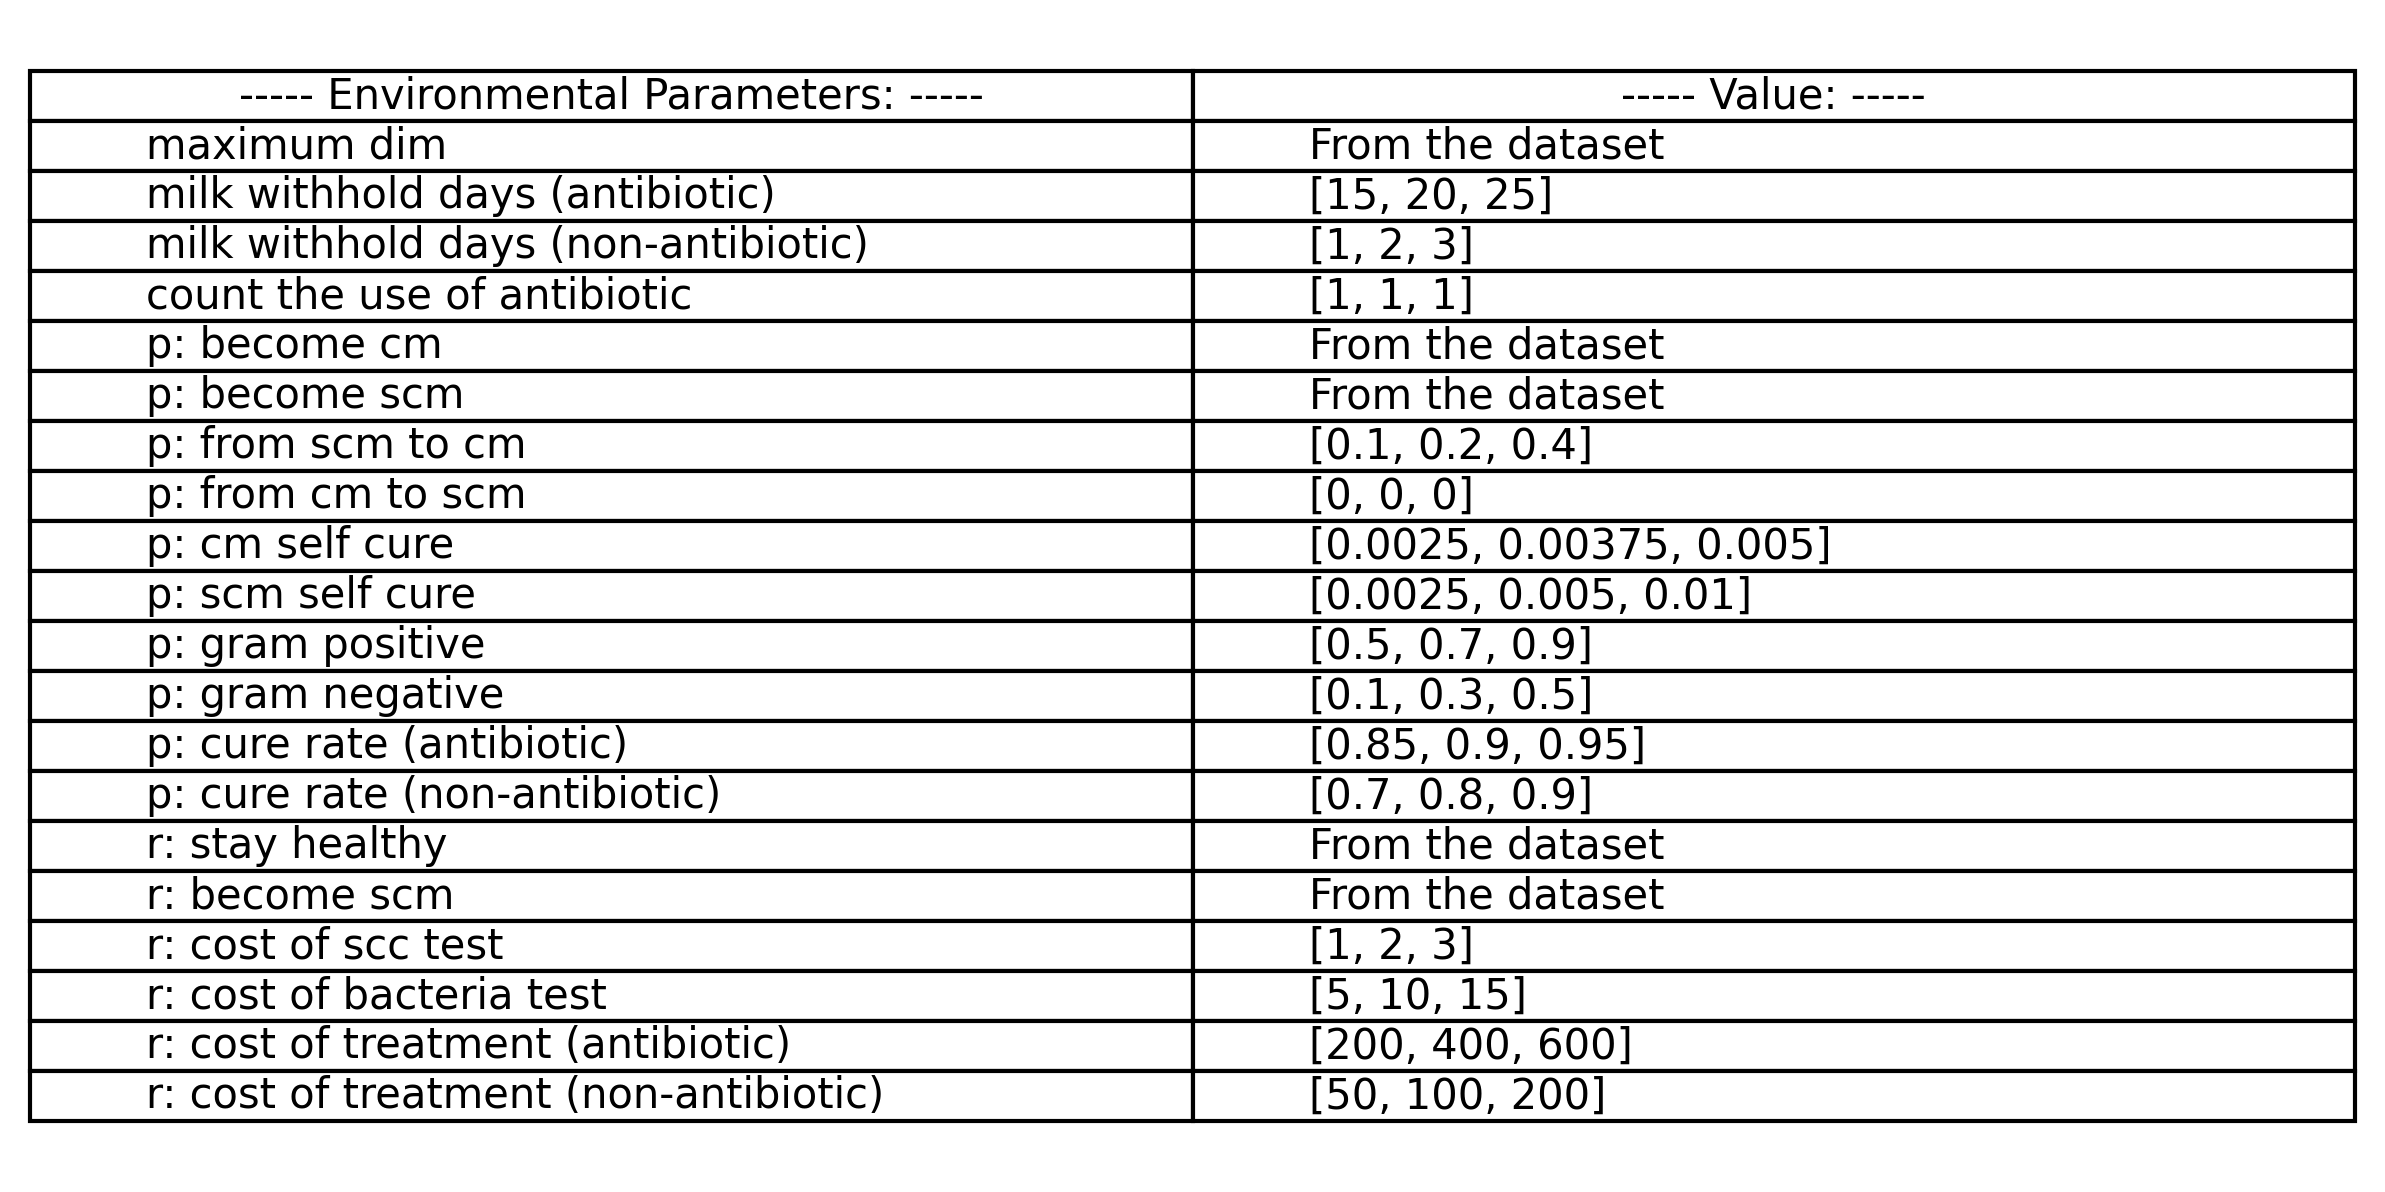

In [14]:
print("here we print the environmental infomation")

# build a dict for printing 
ls_pick_info_print = ['maximum dim', 'milk withhold days (antibiotic)', 'milk withhold days (non-antibiotic)', 'count the use of antibiotic', 'p: become cm', 'p: become scm', 'p: from scm to cm', 'p: from cm to scm', 'p: cm self cure', 'p: scm self cure', 'p: gram positive', 'p: gram negative', 'p: cure rate (antibiotic)', 'p: cure rate (non-antibiotic)', 'r: stay healthy', 'r: become scm', 'r: cost of scc test', 'r: cost of bacteria test', 'r: cost of treatment (antibiotic)', 'r: cost of treatment (non-antibiotic)']

# take the middle value to test the 3 methods below 
key_ls = [i for i in ls_pick_info_print]
value_ls = [env_info_interval[i] for i in env_info_interval]
env_info_print = {key : value for key, value in zip (key_ls, value_ls)}

# reset some values 
env_info_print['maximum dim'] = "From the dataset"
env_info_print['p: become cm'] = "From the dataset"
env_info_print['p: become scm'] = "From the dataset"
env_info_print['r: stay healthy'] = "From the dataset"
env_info_print['r: become scm'] = "From the dataset"

# Example dictionary
data = env_info_print

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(data.items()), columns=['----- Environmental Parameters: -----', '----- Value: -----'])

# Plot the DataFrame as a table
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='left', loc='center')

# Display the table
plt.show()

# Fixed Policy Agent

In [15]:
print("using simple policies in agent_step... ")
class TDAgent(BaseAgent):
    
    def agent_init(self, verbose=False):
        # init the first action 
        self.action = 0
        self.printing = verbose

    def agent_step_base_method(self, state):
        """
        Func: 
            
        Args:
            reward (float): the reward received for taking the last action taken
            state (string): the state from the environment's step after the last action
        Returns:
            the action the agent is taking.
        """
        # choosing whether to treat
        # if state is scm_find or cm, treat
        if state == 2: 
            action = 2
            
        # else, not treat
        else: 
            action = 0

        if self.printing:
            print("action: ", actions_ls[action])
        return action
    
    def agent_step_scm_test(self, state, test_freq=3):
        # access the global variable 
        # global env
        """
        Func: 
            SCC test every test_freq=3 days, treat scm_find with nonantibiotic and cm with antibiotic
        Args:
            reward (float): the reward received for taking the last action taken
            state (string): the state from the environment's step after the last action
        Returns:
            the action the agent is taking.
        """
        ## 1. choosing whether to test
        # e.g. test it every 7 days when is if in health/scm
        if env.days % test_freq == 0 and state in [0, 1]: 
            action = 1

        ## 2. choosing whether to treat
        # if state is cm, do a bact_test
        elif state == 2: 
            action = 3
 
        # use nonanti_treat if find gram_neg or scm_find
        elif state in [3, 5]:
            action = 4

        # use treat if find gram_pos 
        elif state == 4:
            action = 2
        
        # else, not treat
        else: 
            action = 0

        if self.printing:
            print("action: ", actions_ls[action])
        return action
    
    def agent_step_bact_test(self, state): 
        """
        Func: 
            use a bacteria test after scm_find, use non antibiotic treatment if test result is gram neg
        Args:
            reward (float): the reward received for taking the last action taken
            state (string): the state from the environment's step after the last action
        Returns:
            the action the agent is taking.
        """
        
        ## 0. if state is health or scm, action is nothing
        if state == 0 or state == 1: 
            # do nothing
            action = 0

        ## 1. do bactria test if is in state: scm_find, cm
        # if state is cm, treat
        elif state == 2: 
            # do bacteria test 
            action = 3
            
        ## 2. if we have the result from bact_test: select treatment
        # use nonanti_treat if find gram_neg 
        elif state == 5:
            action = 4

        # use treat if find gram_pos 
        elif state == 4:
            action = 2

        if self.printing:
            print("action: ", actions_ls[action])
        return action

using simple policies in agent_step... 


# Q-Learning Agent

In [16]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import agent
from tqdm import tqdm
import pickle

# Q-Learning agent here
class QLearningAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])

        # try init the action 
        self.action = 0
        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # always start with nothing 
        action = 0
        state = 0
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state, verbose=False):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        ## 1. If meets healthy or scm: can only do nothing or test if meets healthy or scm 
        if state == 0 or state == 1: 
            # only pick the action 0 and 1: nothing or test
            current_q = self.q[state, :2]
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(len(self.q[state, :2]))
            else:
                action = self.argmax(current_q)
        
        ## 2. If meets cm 
        elif state == 2 :
            # can pick nothing, bact_test, treat, non_anti_treat 
            columns_to_pick = [0, 2, 3, 4]
            current_q = self.q[state, columns_to_pick]
            if self.rand_generator.rand() < self.epsilon:
                action = self.rand_generator.randint(len(self.q[state, columns_to_pick]))
            else:
                action = self.argmax(current_q)
            # adjust the index of action 
            if action != 0: action += 1
                
        # do nonanti_treat for scm_find
        elif state == 3: 
            current_q = self.q[3, 4]
            action = 4
        
        ## 3. else if we have the result from bact_test 
        # do treat for gram_pos
        elif state == 4: 
            current_q = self.q[4, 2]
            action = 2
        
        # do nonanti_treat for gram neg
        elif state == 5: 
            current_q = self.q[5, 4]
            action = 4
            
        else: 
            print("error: agent_step unresolved state")
        
        # Perform an update (1 line) based on state and action
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = state
        self.prev_action = action
        
        # print action or not 
        if verbose: 
            print("agent_step: ", actions_ls[action])
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])

        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    
# init parameters for Q-agent
agent_info = {"num_actions": len(actions_ls), "num_states": len(states_ls), "epsilon": 0.1, "step_size": 0.5, "discount": 1.0, "seed":2024}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)

# init the q-value 
current_agent.q = np.zeros((current_agent.num_states, current_agent.num_actions)) # The array of action-value estimates.
# init bact_test to guaranten the exploration
current_agent.q[2, 3] = 10000000
current_agent.q[3, 3] = 10000000
action = current_agent.agent_start(0)

print("set up basic info for agent: \n", agent_info)
print("Action Value Estimates: \n", current_agent.q)
print("Action:", action)

set up basic info for agent: 
 {'num_actions': 5, 'num_states': 6, 'epsilon': 0.1, 'step_size': 0.5, 'discount': 1.0, 'seed': 2024}
Action Value Estimates: 
 [[       0.        0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.]
 [       0.        0.        0. 10000000.        0.]
 [       0.        0.        0. 10000000.        0.]
 [       0.        0.        0.        0.        0.]
 [       0.        0.        0.        0.        0.]]
Action: 0


#  ===== Experiment on individual herds ===== 

In [17]:
"""
func: 
    do a fix method by herd 
args: 
    df_herd: df of a herd 
    method_idx: int(0, 1, 2) indicating 3 fix method
return: 
    ave_re, std_re, ave_anti, std_anti: float
"""
def fix_methods_by_herd(df_herd, env_info, method_idx, VERBOSE):
    # init cummulative reward 
    cum_reward_ls = []
    # init cummulative 
    cum_anti_ls = []
    # init count_scm 
    count_scm = 0
    # init class of environment
    env = FarmEnvironment()
    env.env_init(env_info, verbose=VERBOSE)
    # init class of agent 
    agent = TDAgent()
    agent.agent_init(verbose=VERBOSE)
    # init index of animal 
    list_anm_idx = df_herd['anm_ida'].unique().tolist()

    # iterate animal by idx 
    for idx in list_anm_idx:
        # init and extract from an animal
        df_cow = df_herd[df_herd['anm_ida'] == idx]
        mk_wgt = df_cow['mk_wgt'].tolist()
        scc_max = df_cow['scc_max'].tolist()

        # increase chance of infection by the last animal 
        if count_scm >= 5 and np.random.uniform(0, 1, 1) < 0.9:
            scc_max[int(len(scc_max)//2)] = 1
            if VERBOSE:
                print(">>>>>>>>>>>>>>>>> set scm: ", count_scm)

        # reset count_scm 
        count_scm = 0 
        # iterate days in an animal
        for i in range(len(mk_wgt)): 

            """using func env_step to get r_s_t[reward, state, terminal]"""
            env.reward_state_term = env.env_step(agent.action, int(mk_wgt[i]), scc_max[i])

            # count numuber of scm 
            if env.reward_state_term[1] == 1:
                count_scm += 1
                if VERBOSE:
                    print("-------------------------- count_scm: ", count_scm)

            """using func agent_step to get action"""
            if method_idx == 0:
                agent.action = agent.agent_step_base_method(env.reward_state_term[1])
            elif method_idx == 1:
                agent.action = agent.agent_step_scm_test(env.reward_state_term[1])
            elif method_idx == 2:
                agent.action = agent.agent_step_bact_test(env.reward_state_term[1])
                
        # append to the cum_reward_ls
        cum_reward_ls.append(env.reward_state_term[0])
        # append to the cum_anti_ls
        cum_anti_ls.append(env.antibiotic)
        # cleanup for the next agent
        env.env_cleanup(0)

    ave_re, ave_anti = np.array(cum_reward_ls).mean(), np.array(cum_anti_ls).mean()
    std_re, std_anti = np.sqrt(np.array(cum_reward_ls).var()), np.sqrt(np.array(cum_anti_ls).var())
    if VERBOSE:
        print("average of rewards and antibiotic: ", ave_re, ave_anti)
        print("standard variance of rewards and antibiotic: ", std_re, std_anti)
    
    return ave_re, std_re, ave_anti, std_anti

In [18]:
"""
func: 
    run q learning agents by herd
args: 
    df_herd: df of a herd 
    agent_info: (dict) parameter for q agent
    VERBOSE: bool
return: 
    ave_re, std_re, ave_anti, std_anti: float
"""
def q_agent_by_herd(df_herd, agent_info, VERBOSE):
    # init cummulative reward 
    cum_reward_ls = [] 
    # init cummulative 
    cum_anti_ls = []
    # init class of environment
    env = FarmEnvironment()
    env.env_init(env_info, verbose=VERBOSE)
    # init class of agent 
    agent = QLearningAgent() 
    # init info of agent
    agent.agent_init(agent_info) 
    # init the q-value 
    agent.q = np.zeros((agent.num_states, agent.num_actions)) 
    # init bact_test to guaranten the exploration
    agent.q[2, 3] = 10000
    agent.q[3, 3] = 10000
    # agent start 
    agent.agent_start(env.state)
    # init index of animal 
    list_anm_idx = df_herd['anm_ida'].unique().tolist()
    # init count_scm 
    count_scm = 0

    # iterate animal by idx 
    for idx in list_anm_idx:
        # init and extract from an animal
        df_cow = df_herd[df_herd['anm_ida'] == idx]
        mk_wgt = df_cow['mk_wgt'].tolist()
        scc_max = df_cow['scc_max'].tolist()

        # increase chance of infection by the last animal 
        if count_scm >= 5 and np.random.uniform(0, 1, 1) < 0.9:
            scc_max[int(len(scc_max)//2)] = 1
            if VERBOSE:
                print(">>>>>>>>>>>>>>>>> set scm: ", scc_max[int(len(scc_max)//2)])
                
        # reset count_sum 
        count_sum = 0 
        # iterate days for an animal
        for i in range(len(mk_wgt)): 

            """using func env_step to get r_s_t[reward, state, terminal]"""
            env.reward_state_term = env.env_step(agent.action, int(mk_wgt[i]), scc_max[i])

            # count numuber of scm 
            if env.reward_state_term[1] == 1:
                count_scm += 1
                if VERBOSE:
                    print("------------------------- count_scm: ", count_scm)
                    
            """using func agent_step to get action"""
            agent.action = agent.agent_step(env.reward_state_term[0], env.reward_state_term[1], verbose=VERBOSE)


        # append to the cum_reward_ls
        cum_reward_ls.append(env.reward_state_term[0])
        # append to the cum_anti_ls
        cum_anti_ls.append(env.antibiotic)
        # cleanup for the next agent
        env.env_cleanup(0)
        # restart the agent: end and start 
        agent.agent_end(env.reward_state_term[0])
        # agent start 
        agent.agent_start(env.state)

    ave_re, ave_anti = np.array(cum_reward_ls).mean(), np.array(cum_anti_ls).mean()
    std_re, std_anti = np.sqrt(np.array(cum_reward_ls).var()), np.sqrt(np.array(cum_anti_ls).var())
    if VERBOSE:
        print("average of rewards and antibiotic: ", ave_re, ave_anti)
        print("standard variance of rewards and antibiotic: ", std_re, std_anti)
    
    return ave_re, std_re, ave_anti, std_anti, agent

In [25]:
# df of herd
df_herd = df_test[df_test['hrd_ida'] == 1]
# test 
df_herd = df_herd[300:600]
# set verbose for all
VERBOSE = False


In [19]:
"""
func: 
    for a given herd, test 4 methods
args: 
    df_herd: df of a herd
    agent_info: parameter for q-agent
return: 
    average_reward: (list) from 4 methods: base, scc_test, bact_test, q_agent
    ranks: ranks of 4 methods
"""
def four_methods_by_herd(df_herd, agent_info, env_info):
    # init results
    average_reward = []
    """call func: """
    ave_re, std_re, ave_anti, std_anti = fix_methods_by_herd(df_herd, env_info, 0, False)
    average_reward.append(ave_re)
    ave_re, std_re, ave_anti, std_anti = fix_methods_by_herd(df_herd, env_info, 1, False)
    average_reward.append(ave_re)
    ave_re, std_re, ave_anti, std_anti = fix_methods_by_herd(df_herd, env_info, 2, False)
    average_reward.append(ave_re)
    ave_re, std_re, ave_anti, std_anti, _ = q_agent_by_herd(df_herd, agent_info, False)
    average_reward.append(ave_re)
    
    """call func"""
    return average_reward, rank_elements(average_reward)

"""
func: 
    a helper function for ranking 
arg: 
    lst: list 
return: 
    list
"""
def rank_elements(lst):
    # Create a sorted list of unique elements
    sorted_lst = sorted(set(lst), reverse=True)
    
    # Create a dictionary to map each element to its rank
    rank_dict = {element: rank + 1 for rank, element in enumerate(sorted_lst)}
    
    # Map the original list to their respective ranks
    return [rank_dict[element] for element in lst]

# General results

In [36]:
"""
func: 
    for a given herd, test 4 methods
args: 
    df_herd: df of a herd
    agent_info: parameter for q-agent
return: 
    average_reward: (list) from 4 methods: base, scc_test, bact_test, q_agent
    ranks: ranks of 4 methods
"""
def four_methods_plot(df_herd, agent_info, env_info):
    # init results
    ls_average_re, ls_std_re = [], []
    ls_average_anti, ls_std_anti = [], []
    
    """call func: """
    ave_re, std_re, ave_anti, std_anti = fix_methods_by_herd(df_herd, env_info, 0, False)
    ls_average_re.append(ave_re)
    ls_std_re.append(std_re)
    ls_average_anti.append(ave_anti)
    ls_std_anti.append(std_anti)
    
    ave_re, std_re, ave_anti, std_anti = fix_methods_by_herd(df_herd, env_info, 1, False)
    ls_average_re.append(ave_re)
    ls_std_re.append(std_re)
    ls_average_anti.append(ave_anti)
    ls_std_anti.append(std_anti)
    
    ave_re, std_re, ave_anti, std_anti = fix_methods_by_herd(df_herd, env_info, 2, False)
    ls_average_re.append(ave_re)
    ls_std_re.append(std_re)
    ls_average_anti.append(ave_anti)
    ls_std_anti.append(std_anti)
    
    ave_re, std_re, ave_anti, std_anti, _ = q_agent_by_herd(df_herd, agent_info, False)
    ls_average_re.append(ave_re)
    ls_std_re.append(std_re)
    ls_average_anti.append(ave_anti)
    ls_std_anti.append(std_anti)
    
    """call func"""
    plot_4methods(ls_average_re, ls_std_re, "Economic return per cow per lactation records")
    ls_average_anti =  [0.1*i for i in ls_average_anti]
    ls_std_anti =  [0.1*i for i in ls_std_anti]
    plot_4methods(ls_average_anti, ls_std_anti, "Antibiotic usage per cow per lactation records")
        
"""
func: 
    helper func
args: 
    ls_average, ls_std: list[float]
    YLABEL: str
"""
def plot_4methods(ls_average, ls_std, YLABEL): 

    # Set default DPI for all figures
    plt.rcParams['figure.dpi'] = 200

    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i,int(y[i])+500,int(y[i]), ha = 'center')

    # making a simple plot
    method_ls = ['Baseline', 'SCC test', 'Bacteria test', 'Q-agent']

    # Plot scatter here
    plt.bar(method_ls, ls_average, color="indigo")
    plt.errorbar(method_ls, ls_average, yerr=ls_std, fmt="o", color="limegreen")
    # add values on top 
    if YLABEL == "Economic return per cow per lactation records":
        addlabels(method_ls, ls_average)
    plt.xlabel("Four methods in mastitis management")
    plt.ylabel(YLABEL)
    plt.show()

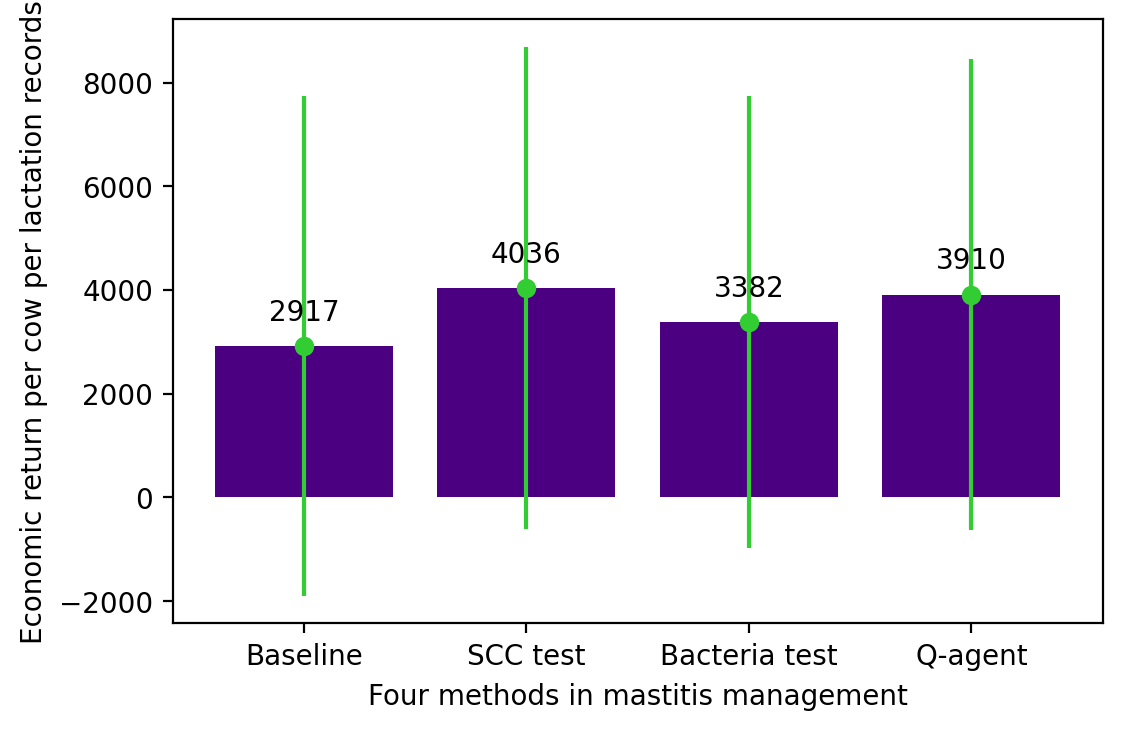

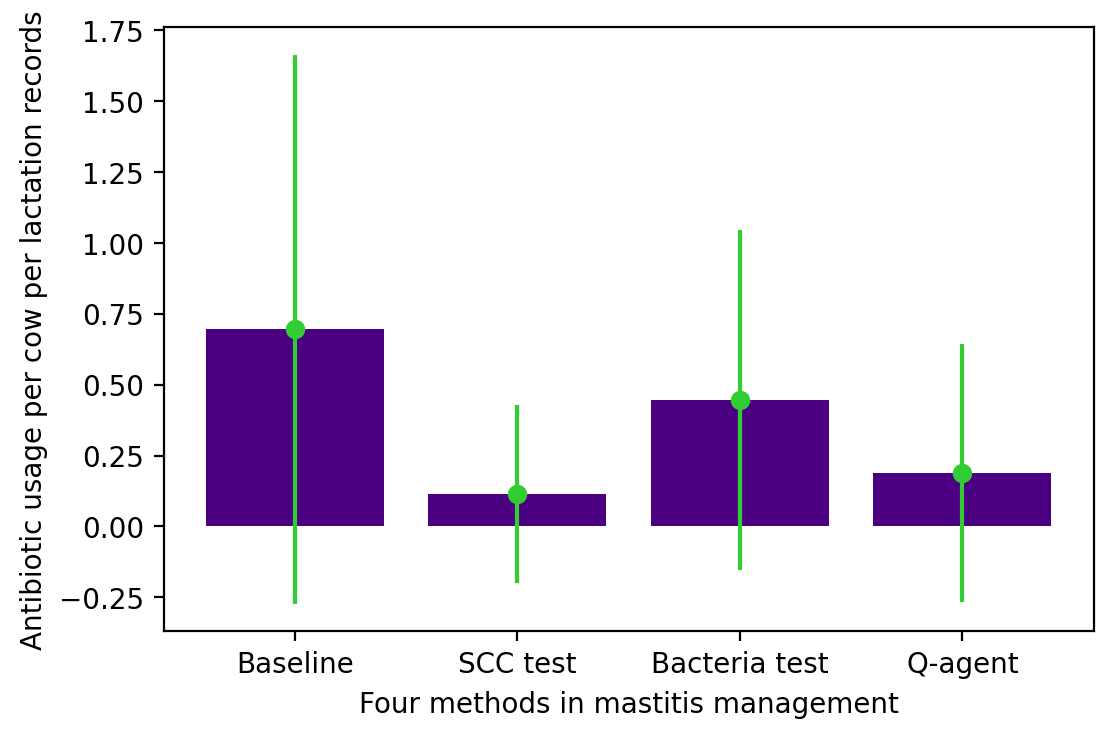

In [37]:
"""call func"""
four_methods_plot(df_train, agent_info, env_info)

# Experimenting 

In [26]:
print("experimenting 4 methods for all herds")
# idx of all herds 
idx_herds = df_test['hrd_ida'].unique().tolist()
print("number of herds: ", len(idx_herds))
# iterate herds
for idx in idx_herds:
    # df of herd
    df_herd = df_test[df_test['hrd_ida'] == idx]
    
    # inspect number of animals 
    num_anm = df_herd['anm_ida'].nunique()
    #print("num_anm: ", num_anm)
    
    # inspect scc recording
    is_all_zeros = (df_herd['scc_max'] == 0).all()
    #print("is_all_zeros: ", is_all_zeros)
    
    # exclude herds with too little animals: < 10 
    if num_anm < 10 or not is_all_zeros: 
        idx_herds.remove(idx)
        
print("number of herds: ", len(idx_herds))

experimenting 4 methods for all herds
number of herds:  52
number of herds:  28


In [27]:
print("experimenting on df_test")
df_data = df_test
# init list to store average_reward, rank
test_average_reward, test_rank = [], []
# iterate herds
for idx in idx_herds:
    # df of herd
    df_herd = df_data[df_data['hrd_ida'] == idx]

    # init class of environment
    env = FarmEnvironment()
    env.env_init(env_info, verbose=VERBOSE)
    # init class of agent 
    agent = TDAgent()
    agent.agent_init(verbose=VERBOSE)
    
    """call func"""
    average_reward, rank = four_methods_by_herd(df_herd, agent_info, env_info)
    #print("average_reward, rank: ", average_reward, rank)
    test_average_reward.append(average_reward)
    test_rank.append(rank)
    

experimenting on df_test


In [28]:
print("experimenting on df_train")
df_data = df_train
# init list to store average_reward, rank
train_average_reward, train_rank = [], []
# iterate herds
for idx in idx_herds:
    # df of herd
    df_herd = df_data[df_data['hrd_ida'] == idx]
    
    # init class of environment
    env = FarmEnvironment()
    env.env_init(env_info, verbose=VERBOSE)
    # init class of agent 
    agent = TDAgent()
    agent.agent_init(verbose=VERBOSE)

    """call func"""
    average_reward, rank = four_methods_by_herd(df_herd, agent_info, env_info)
    #print("average_reward, rank: ", average_reward, rank)
    train_average_reward.append(average_reward)
    train_rank.append(rank)

experimenting on df_train


### Kendall test for rank consistency

In [198]:
print("kendall test for rank consistency")
import numpy as np
from scipy.stats import kendalltau

"""
func: 
    kendell test 
args: 
    train_ranks, test_ranks: list[list[int]] these are list of ranks
return: 
    p-value
"""
def kendall_test_ranks(train_ranks, test_ranks):
    # Calculate Kendall's Tau for each pair of rankings
    kendall_tau_scores = []

    for train_rank, test_rank in zip(train_ranks, test_ranks):
        #print("train_rank, test_rank: ", train_rank, test_rank)
        tau, _ = kendalltau(train_rank, test_rank)
        kendall_tau_scores.append(tau)

    # Average Kendall's Tau to get an overall measure of consistency
    observed_overall_consistency = np.mean(kendall_tau_scores)

    # Perform permutation test to get empirical distribution of average Kendall's Tau
    n_permutations = 10000
    permuted_tau_scores = []

    for _ in range(n_permutations):
        permuted_test_ranks = [np.random.permutation(r) for r in test_ranks]
        permuted_taus = []

        for train_rank, perm_test_rank in zip(train_ranks, permuted_test_ranks):
            tau, _ = kendalltau(train_rank, perm_test_rank)
            permuted_taus.append(tau)

        permuted_tau_scores.append(np.mean(permuted_taus))

    # Calculate the p-value
    p_value = np.sum(np.array(permuted_tau_scores) >= observed_overall_consistency) / n_permutations

    print("Observed overall consistency (average Kendall's Tau):", observed_overall_consistency)
    print("P-value:", p_value)


kendall test for rank consistency


In [199]:
# Sample data
#train_ranks = [[0, 1, 2, 3], [1, 0, 2, 3], [0, 1, 3, 2]]
#test_ranks = [[0, 1, 2, 3], [1, 0, 2, 3], [0, 1, 2, 3]]
"""call func"""
kendall_test_ranks(train_rank, test_rank)

train_rank, test_rank:  [2, 4, 3, 1] [1, 3, 1, 2]
train_rank, test_rank:  [4, 1, 3, 2] [4, 2, 3, 1]
train_rank, test_rank:  [4, 2, 3, 1] [4, 2, 3, 1]
train_rank, test_rank:  [4, 2, 3, 1] [4, 2, 3, 1]
train_rank, test_rank:  [1, 3, 1, 2] [1, 3, 1, 2]
train_rank, test_rank:  [4, 1, 3, 2] [4, 2, 3, 1]
train_rank, test_rank:  [4, 2, 3, 1] [4, 1, 3, 2]
train_rank, test_rank:  [4, 2, 3, 1] [4, 2, 3, 1]
train_rank, test_rank:  [1, 3, 1, 2] [1, 3, 1, 2]
train_rank, test_rank:  [4, 1, 3, 2] [4, 1, 3, 2]
train_rank, test_rank:  [1, 3, 1, 2] [1, 3, 1, 2]
train_rank, test_rank:  [1, 3, 1, 2] [1, 3, 1, 2]
train_rank, test_rank:  [4, 1, 3, 2] [4, 1, 3, 2]
train_rank, test_rank:  [4, 1, 3, 2] [4, 1, 3, 2]
train_rank, test_rank:  [1, 3, 1, 2] [1, 3, 1, 2]
train_rank, test_rank:  [4, 1, 3, 2] [4, 1, 3, 2]
train_rank, test_rank:  [1, 3, 1, 2] [1, 3, 1, 2]
train_rank, test_rank:  [1, 3, 1, 2] [1, 3, 1, 2]
train_rank, test_rank:  [4, 1, 3, 2] [4, 2, 3, 1]
train_rank, test_rank:  [4, 2, 3, 1] [4, 1, 3, 2]


# ===== Interpretate Experiment =====

In [24]:
"""helper func to count lists in list"""
from collections import Counter
def count_unique_sublists(list_of_lists):
    # Convert each sublist to a tuple to make it hashable and countable by Counter
    tuple_list = [tuple(sublist) for sublist in list_of_lists]
    
    # Use Counter to count the occurrences of each tuple
    sublist_count = Counter(tuple_list)
    
    # Convert back to list format for readability if needed
    #sublist_count = {list(key): value for key, value in sublist_count.items()}
    
    return sublist_count

In [25]:
"""call func: """
counts = count_unique_sublists(train_rank)
print("counts: ", counts)

counts:  Counter({(4, 1, 3, 2): 12, (1, 3, 1, 2): 9, (4, 2, 3, 1): 6, (3, 4, 1, 2): 1})


In [28]:
"""call func: """
counts = count_unique_sublists(test_rank)
print("counts: ", counts)

counts:  Counter({(4, 2, 3, 1): 10, (1, 3, 1, 2): 9, (4, 1, 3, 2): 8, (1, 2, 1, 1): 1})


### Inspect these 3 cluster of herds by box plot

In [32]:
print("inspect these 3 cluster of herds by box plot")

# init list to store 3 idx 
c1, c2, c3 = [], [], [] 
# iterate rank 
for i in range(len(train_rank)):
    if train_rank[i] == [4, 1, 3, 2]: c1.append(idx_herds[i])
    elif train_rank[i] == [1, 3, 1, 2]: c2.append(idx_herds[i])
    elif train_rank[i] == [4, 2, 3, 1]: c3.append(idx_herds[i])

inspect these 3 cluster of herds by box plot


In [35]:
"""
func: 
    helpler func: box plot 
args: 
    df_ls: list of df
    check_column: list[str]
"""
def plot_3box(df_ls, check_column): 

    # create the figure and two subplots
    fig, axes = plt.subplots(ncols=len(check_column), figsize=(20, 15), dpi=250)

    # create the boxplot with Seaborn
    for column, axis in zip(check_column, axes):

        # dealing with nan 
        if df_ls[0][column].isnull().any() or df_ls[-1][column].isnull().any(): 
            #print(column, "nan")
            
            # create a temp df for ploting
            ls_ls = [df[column].dropna().tolist() for df in df_ls]

            axis.boxplot(ls_ls, showfliers=False, boxprops=dict(color="indigo"), medianprops=dict(color="green"))

            # set name
            axis.set_title(column)
            #axis.set(xticklabels=[], xticks=[], ylabel=column)
        else: 
            #print(column)
            # create a temp df for ploting
            ls_ls= [df[column].tolist() for df in df_ls]

            axis.boxplot(ls_ls, showfliers=False, boxprops=dict(color="indigo"), medianprops=dict(color="green"))

            # set name
            axis.set_title(column)
        
    # show the plot
    plt.tight_layout()
    plt.show()
    

In [37]:
df_final = pd.read_csv("../../Data/df_cleaned_normalrange_2024_08_06.csv")

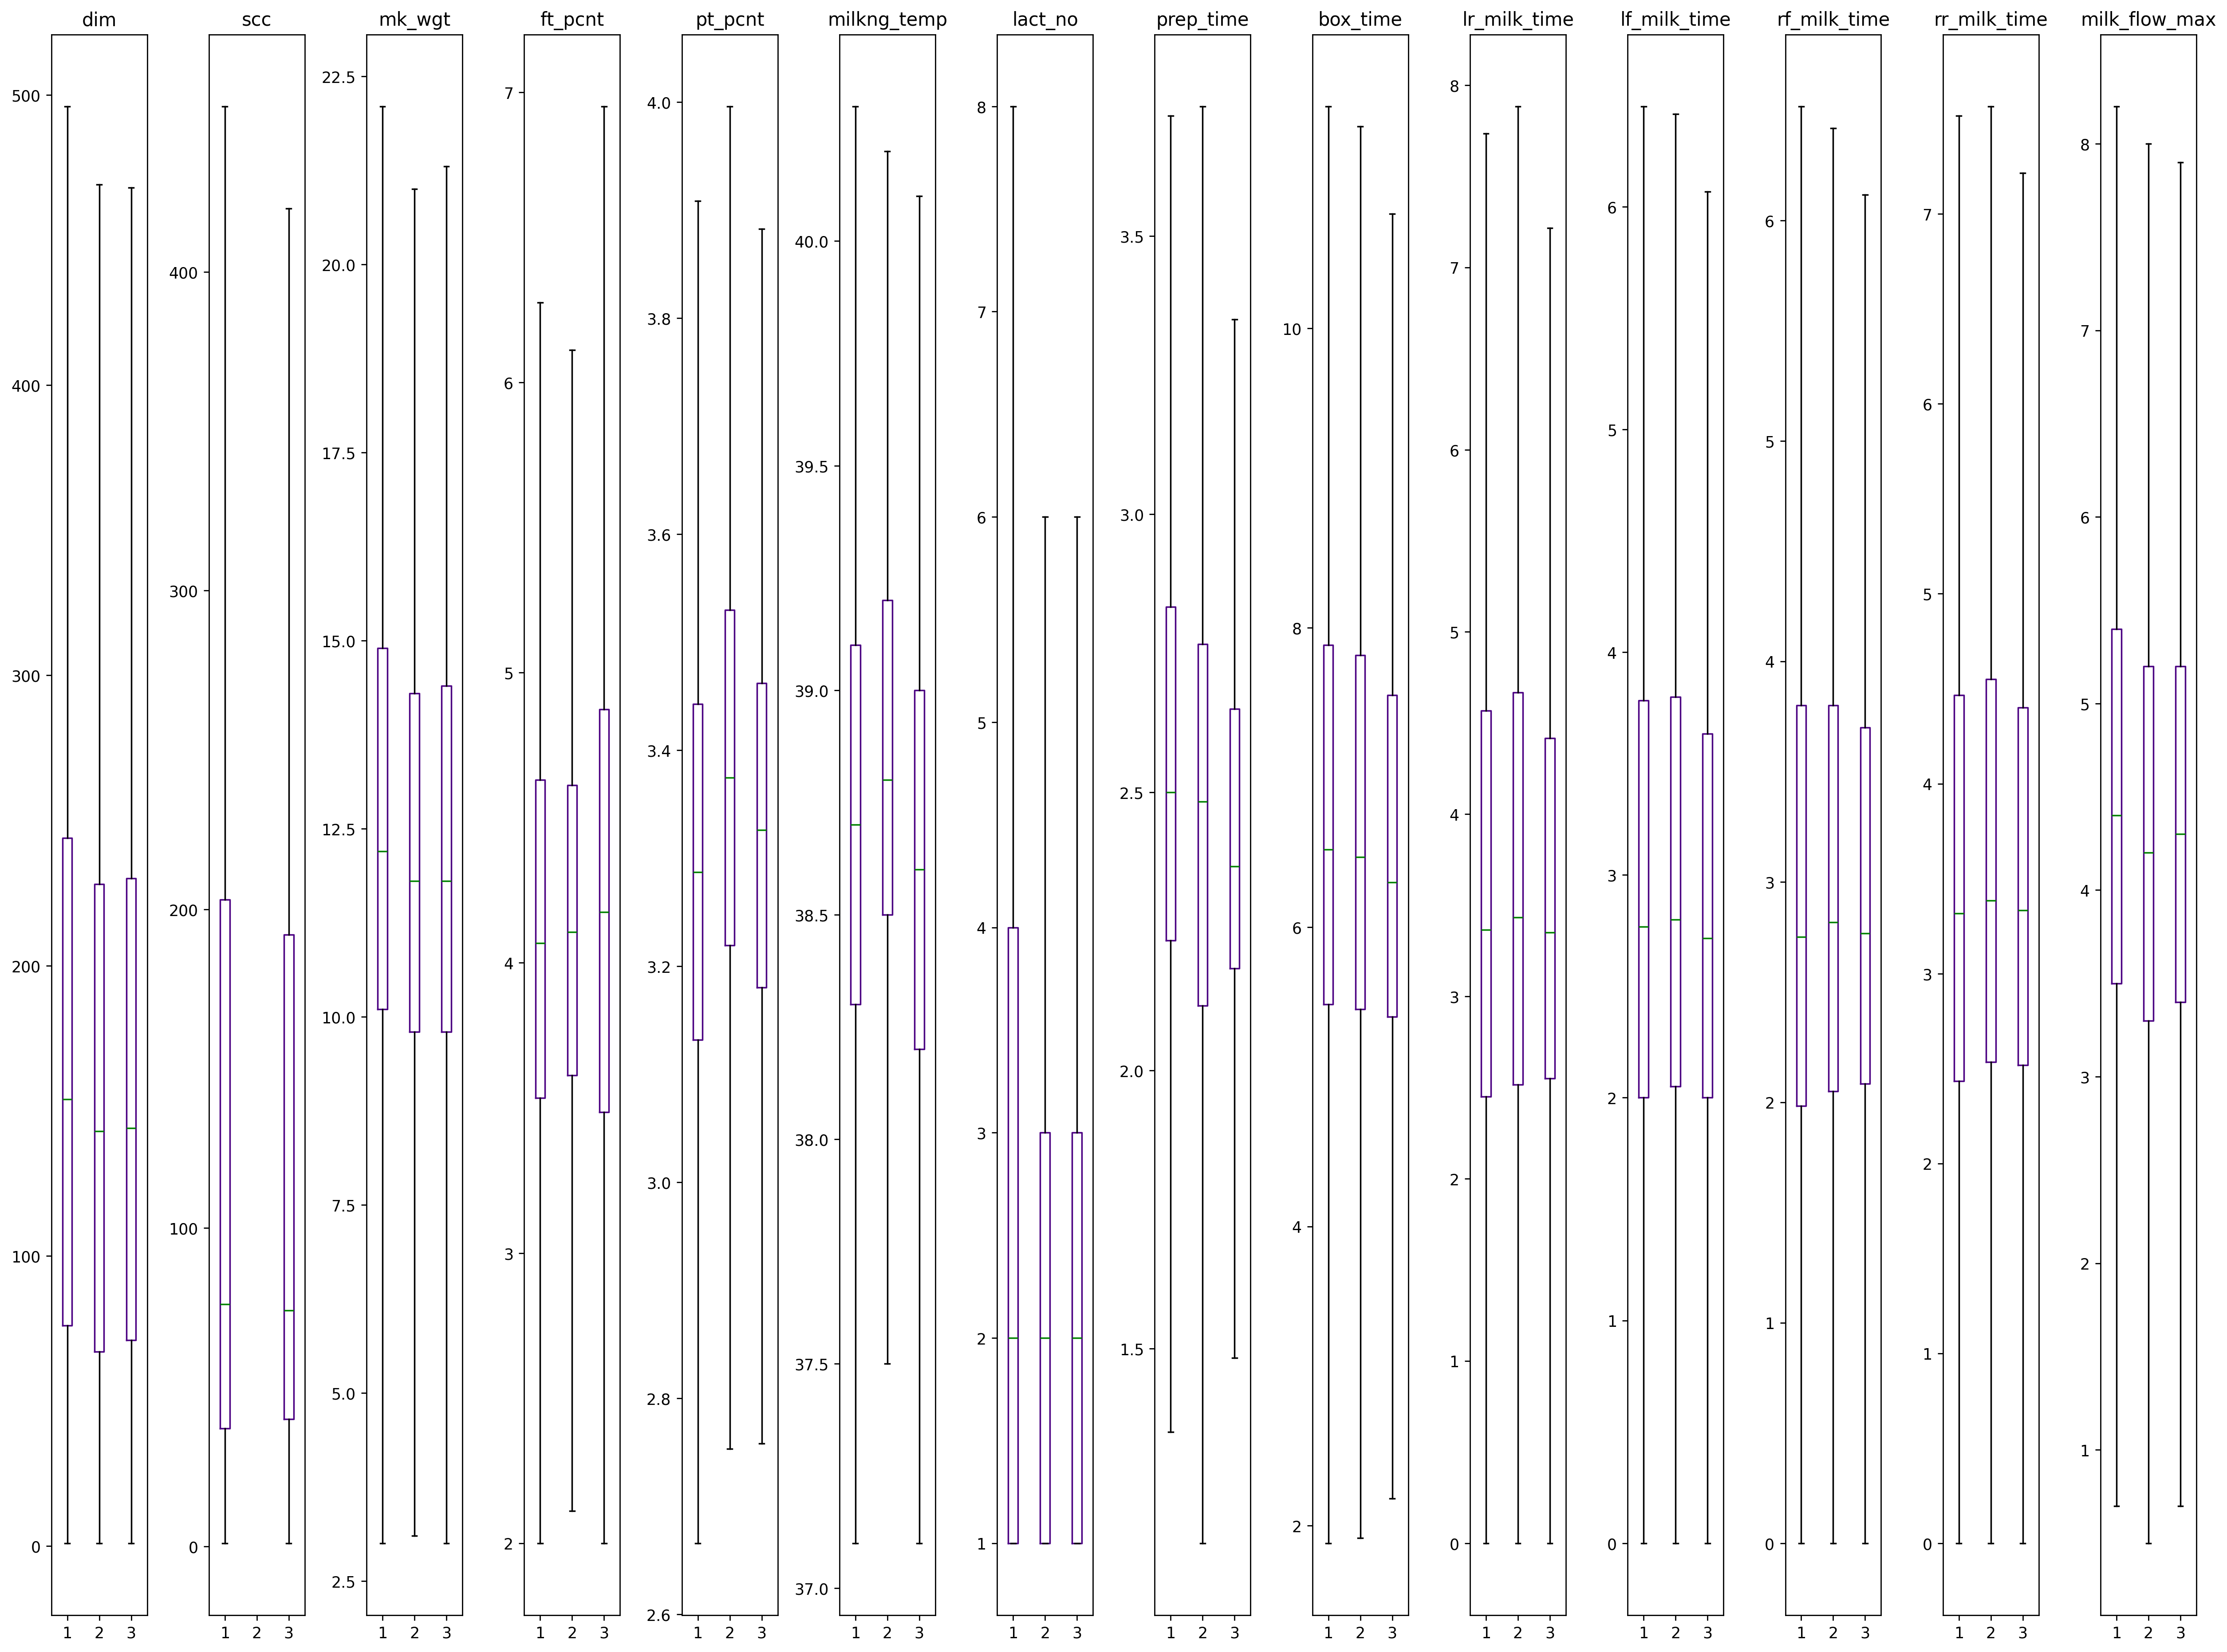

In [39]:
df_ls = [df_final[df_final['hrd_ida'].isin(group_id)] for group_id in [c1, c2, c3]]
column1 = ['dim', 'scc', 'mk_wgt', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'lact_no']
column2 = ['prep_time', 'box_time', 'lr_milk_time', 'lf_milk_time', 'rf_milk_time', 'rr_milk_time',  'milk_flow_max']
"""using func: """
plot_3box(df_ls, column1+column2)

### Distribution of optimal actions

In [66]:
"""
func: 
    helper func
args: 
    rank: list[list[int]]
    sequence: int to get rank 1, 2, 3, 4?
return: 
    list_best: list[int]
"""
def count_best_action(rank, sequence):
    list_best = [0, 0, 0, 0]
    # iterate ranks
    for ls in rank: 
        if sequence in ls:
            # get the idx of that sequence
            idx = ls.index(sequence)
            # add one for that sequence
            list_best[idx] +=1
    return list_best

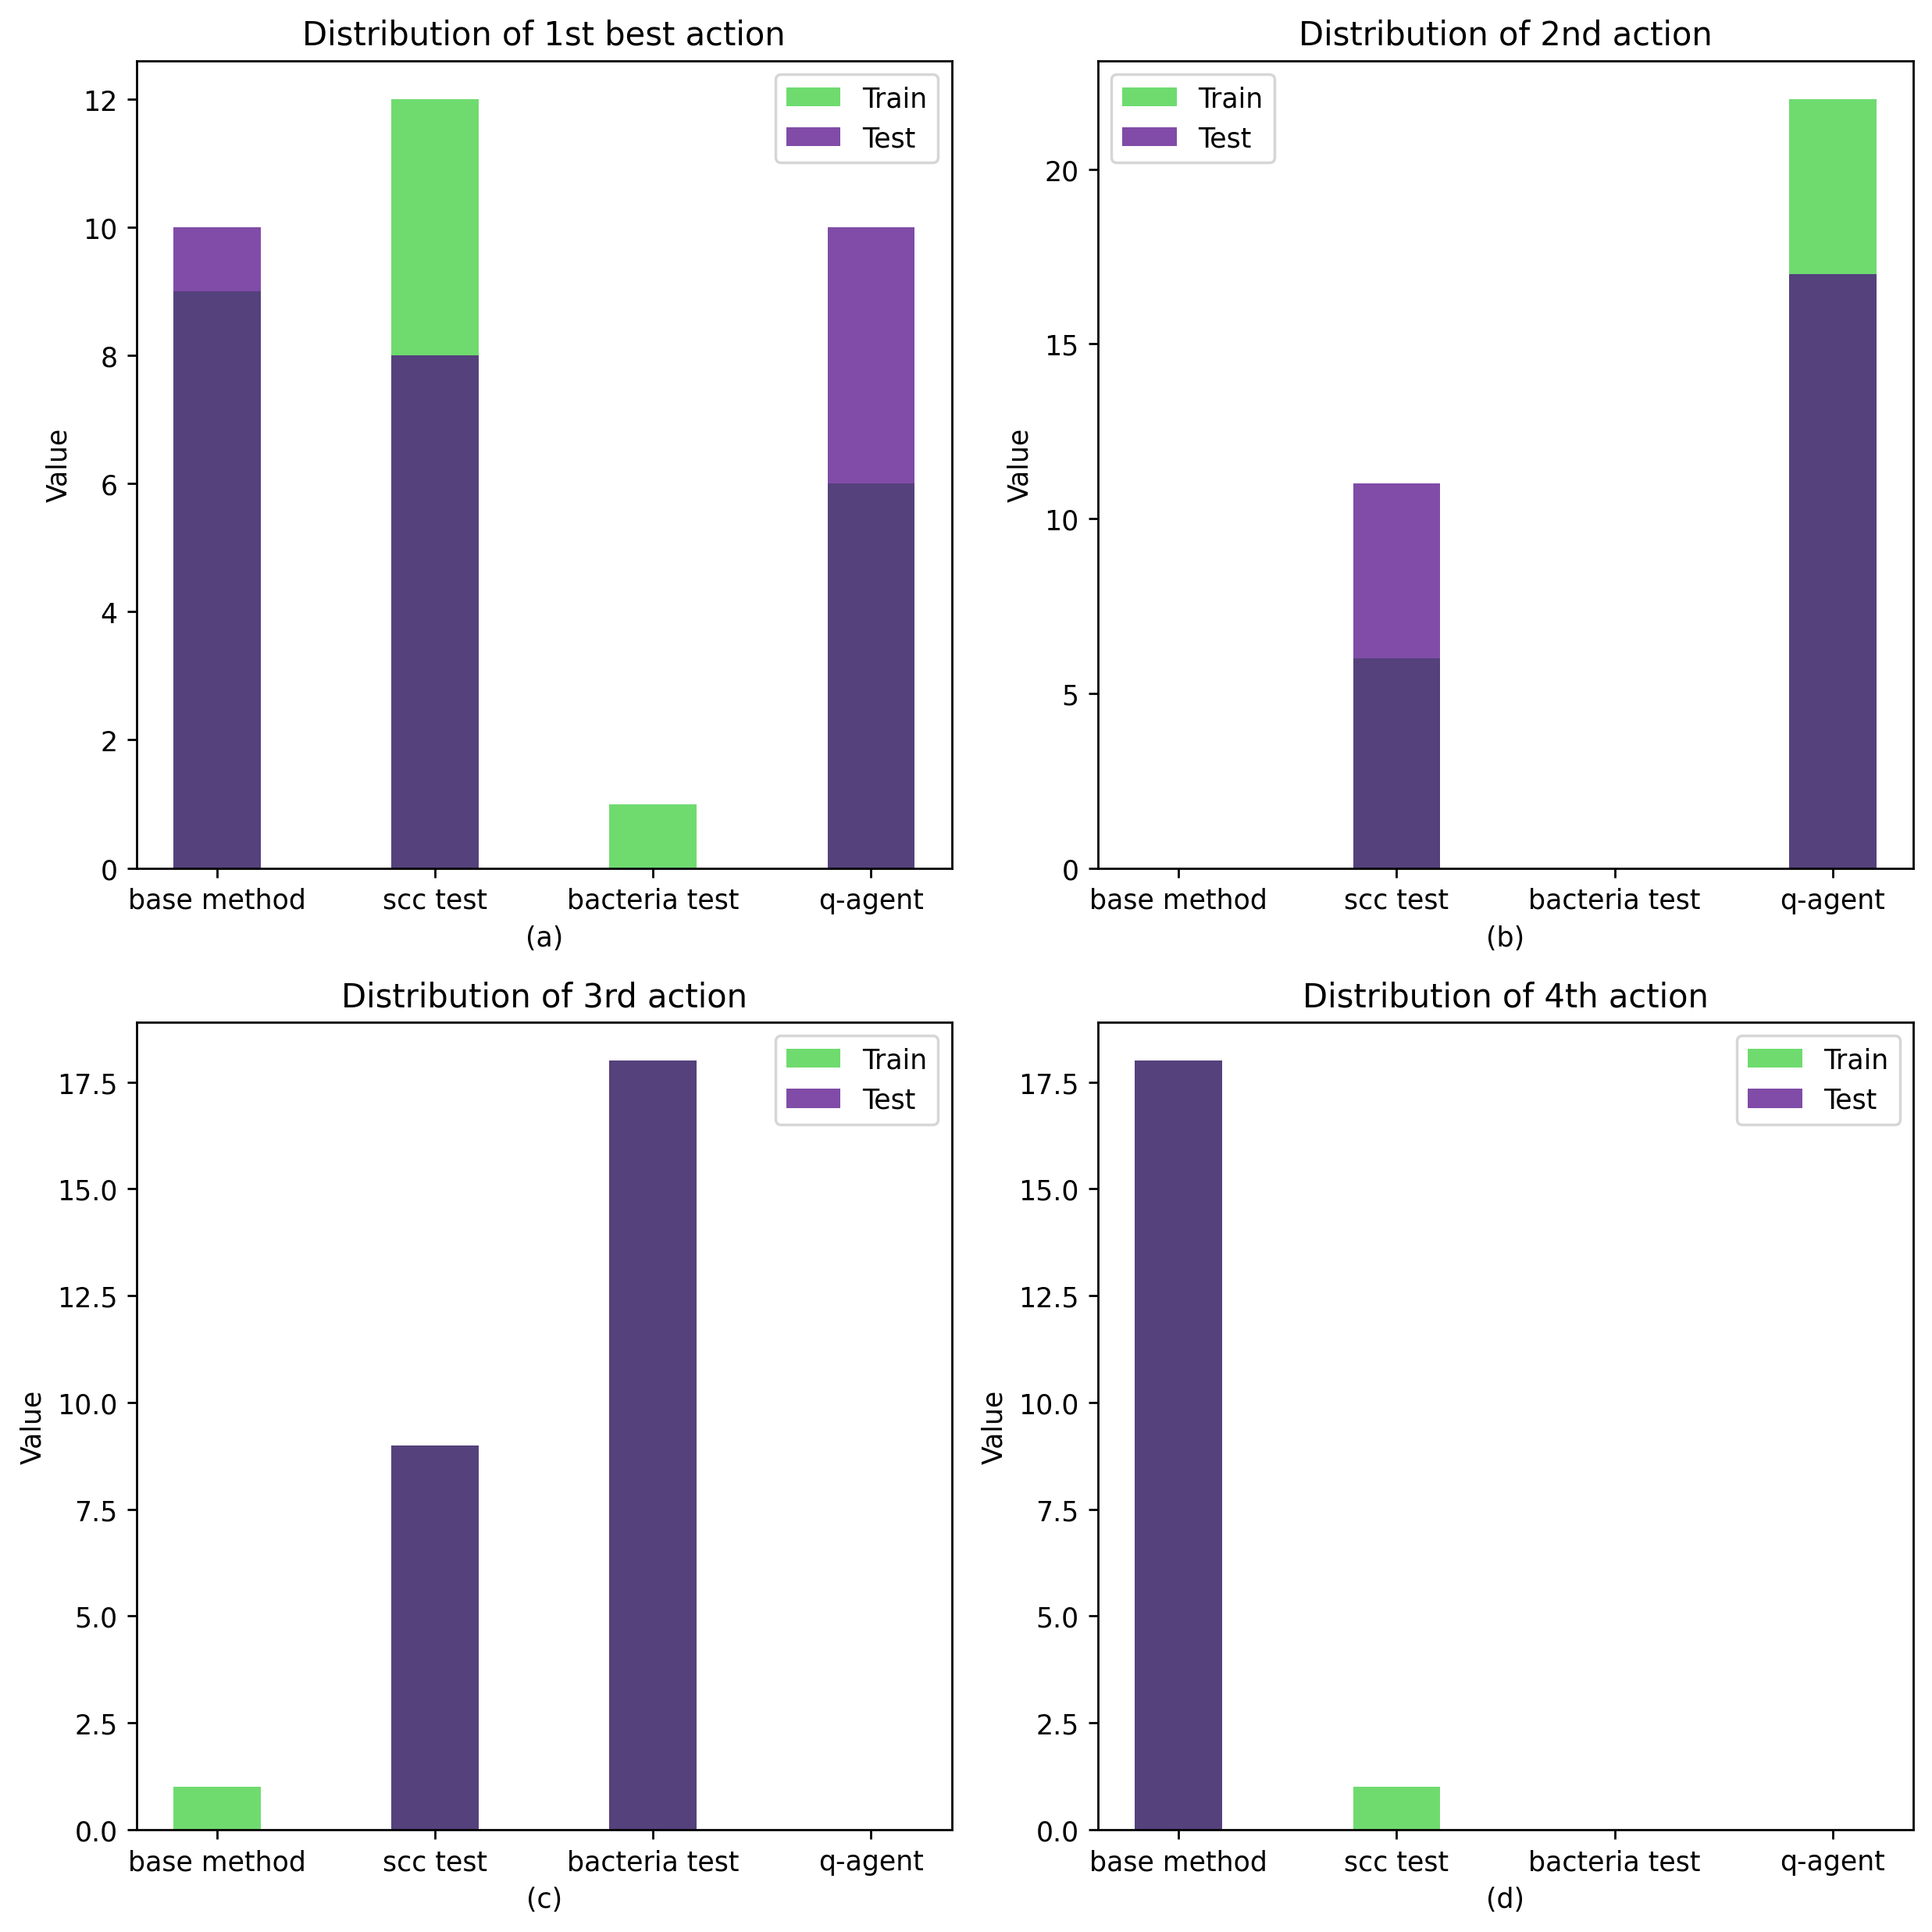

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions(pairs, x_labels, subplot_labels, dpi=250):
    """
    Plot multiple pairs of distributions as subplots.
    
    :param pairs: List of tuples, where each tuple contains two lists (train, test).
    :param x_labels: List of x-axis labels for the plots.
    :param subplot_labels: List of labels for the subplots (e.g., 'a', 'b', 'c', 'd').
    :param dpi: DPI for the figure.
    """
    num_pairs = len(pairs)
    
    # Create a figure with specified DPI and subplots
    plt.figure(figsize=(10, 10), dpi=dpi)
    
    # Init 
    CHAR = ['(a)', '(b)', '(c)', '(d)']
    TITLE = ['Distribution of 1st best action', 'Distribution of 2nd action', 'Distribution of 3rd action', 'Distribution of 4th action']
    
    for i, (train, test) in enumerate(pairs):
        # Positions of bars on the x-axis
        x = np.arange(len(train))
        
        # Create subplot
        plt.subplot(2, 2, i+1)  # Arrange plots in a 2x2 grid
        
        # Plotting the bars
        plt.bar(x, train, color='limegreen', alpha=0.7, label='Train', width=0.4)
        plt.bar(x, test, color='indigo', alpha=0.7, label='Test', width=0.4)
        
        # Adding labels and title
        plt.xlabel(CHAR[i])
        plt.ylabel('Value')
        plt.title(TITLE[i])
        plt.xticks(x, x_labels)  # Set the x-tick marks to correspond with the categories
        plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example data
list_best_train_1 = count_best_action(train_rank, 1)
list_best_test_1 =  count_best_action(test_rank, 1)
list_best_train_2 =  count_best_action(train_rank, 2)
list_best_test_2 =  count_best_action(test_rank, 2)
list_best_train_3 =  count_best_action(train_rank, 3)
list_best_test_3 =  count_best_action(test_rank, 3)
list_best_train_4 =  count_best_action(train_rank, 4)
list_best_test_4 =  count_best_action(test_rank, 4)

pairs = [
    (list_best_train_1, list_best_test_1),
    (list_best_train_2, list_best_test_2),
    (list_best_train_3, list_best_test_3),
    (list_best_train_4, list_best_test_4)
]

x_labels = ['base method', 'scc test', 'bacteria test', 'q-agent']
subplot_labels = ['a', 'b', 'c', 'd']

# Call the function to plot the distributions
plot_distributions(pairs, x_labels, subplot_labels)


# ===== End Experiment =====

# Inspect Q-learning Agent

In [79]:
print("run q-agent")
"""call func"""
df_herd = df_train[df_train['hrd_ida'] == 0]
ave_re, std_re, ave_anti, std_anti, agent = q_agent_by_herd(df_herd, agent_info, False)

run q-agent


### Plotting results of Q-learning

Inspect the optimal policy that Q-learning agent find: 
for state:  health
action ranked:  ['test', 'nothing', 'nonanti_treat', 'bact_test', 'treat']
value ranked:  [3679640.6244000653, 1944910.6494874458, 0.0, 0.0, 0.0]

-------------------------
for state:  scm
action ranked:  ['nothing', 'test', 'nonanti_treat', 'bact_test', 'treat']
value ranked:  [3904745.531011684, 3446149.61672558, 0.0, 0.0, 0.0]

-------------------------
for state:  cm
action ranked:  ['bact_test', 'nothing', 'nonanti_treat', 'treat', 'test']
value ranked:  [3908878.1111865053, 3617099.701411739, 3397084.1301268223, 2912373.7438587304, 0.0]

-------------------------
for state:  scm_find
action ranked:  ['nonanti_treat', 'bact_test', 'treat', 'test', 'nothing']
value ranked:  [3799910.0857516103, 10000.0, 0.0, 0.0, 0.0]

-------------------------
for state:  gram_pos
action ranked:  ['treat', 'nonanti_treat', 'bact_test', 'test', 'nothing']
value ranked:  [3906993.518751026, 0.0, 0.0, 0.0, 0.0]

--------------

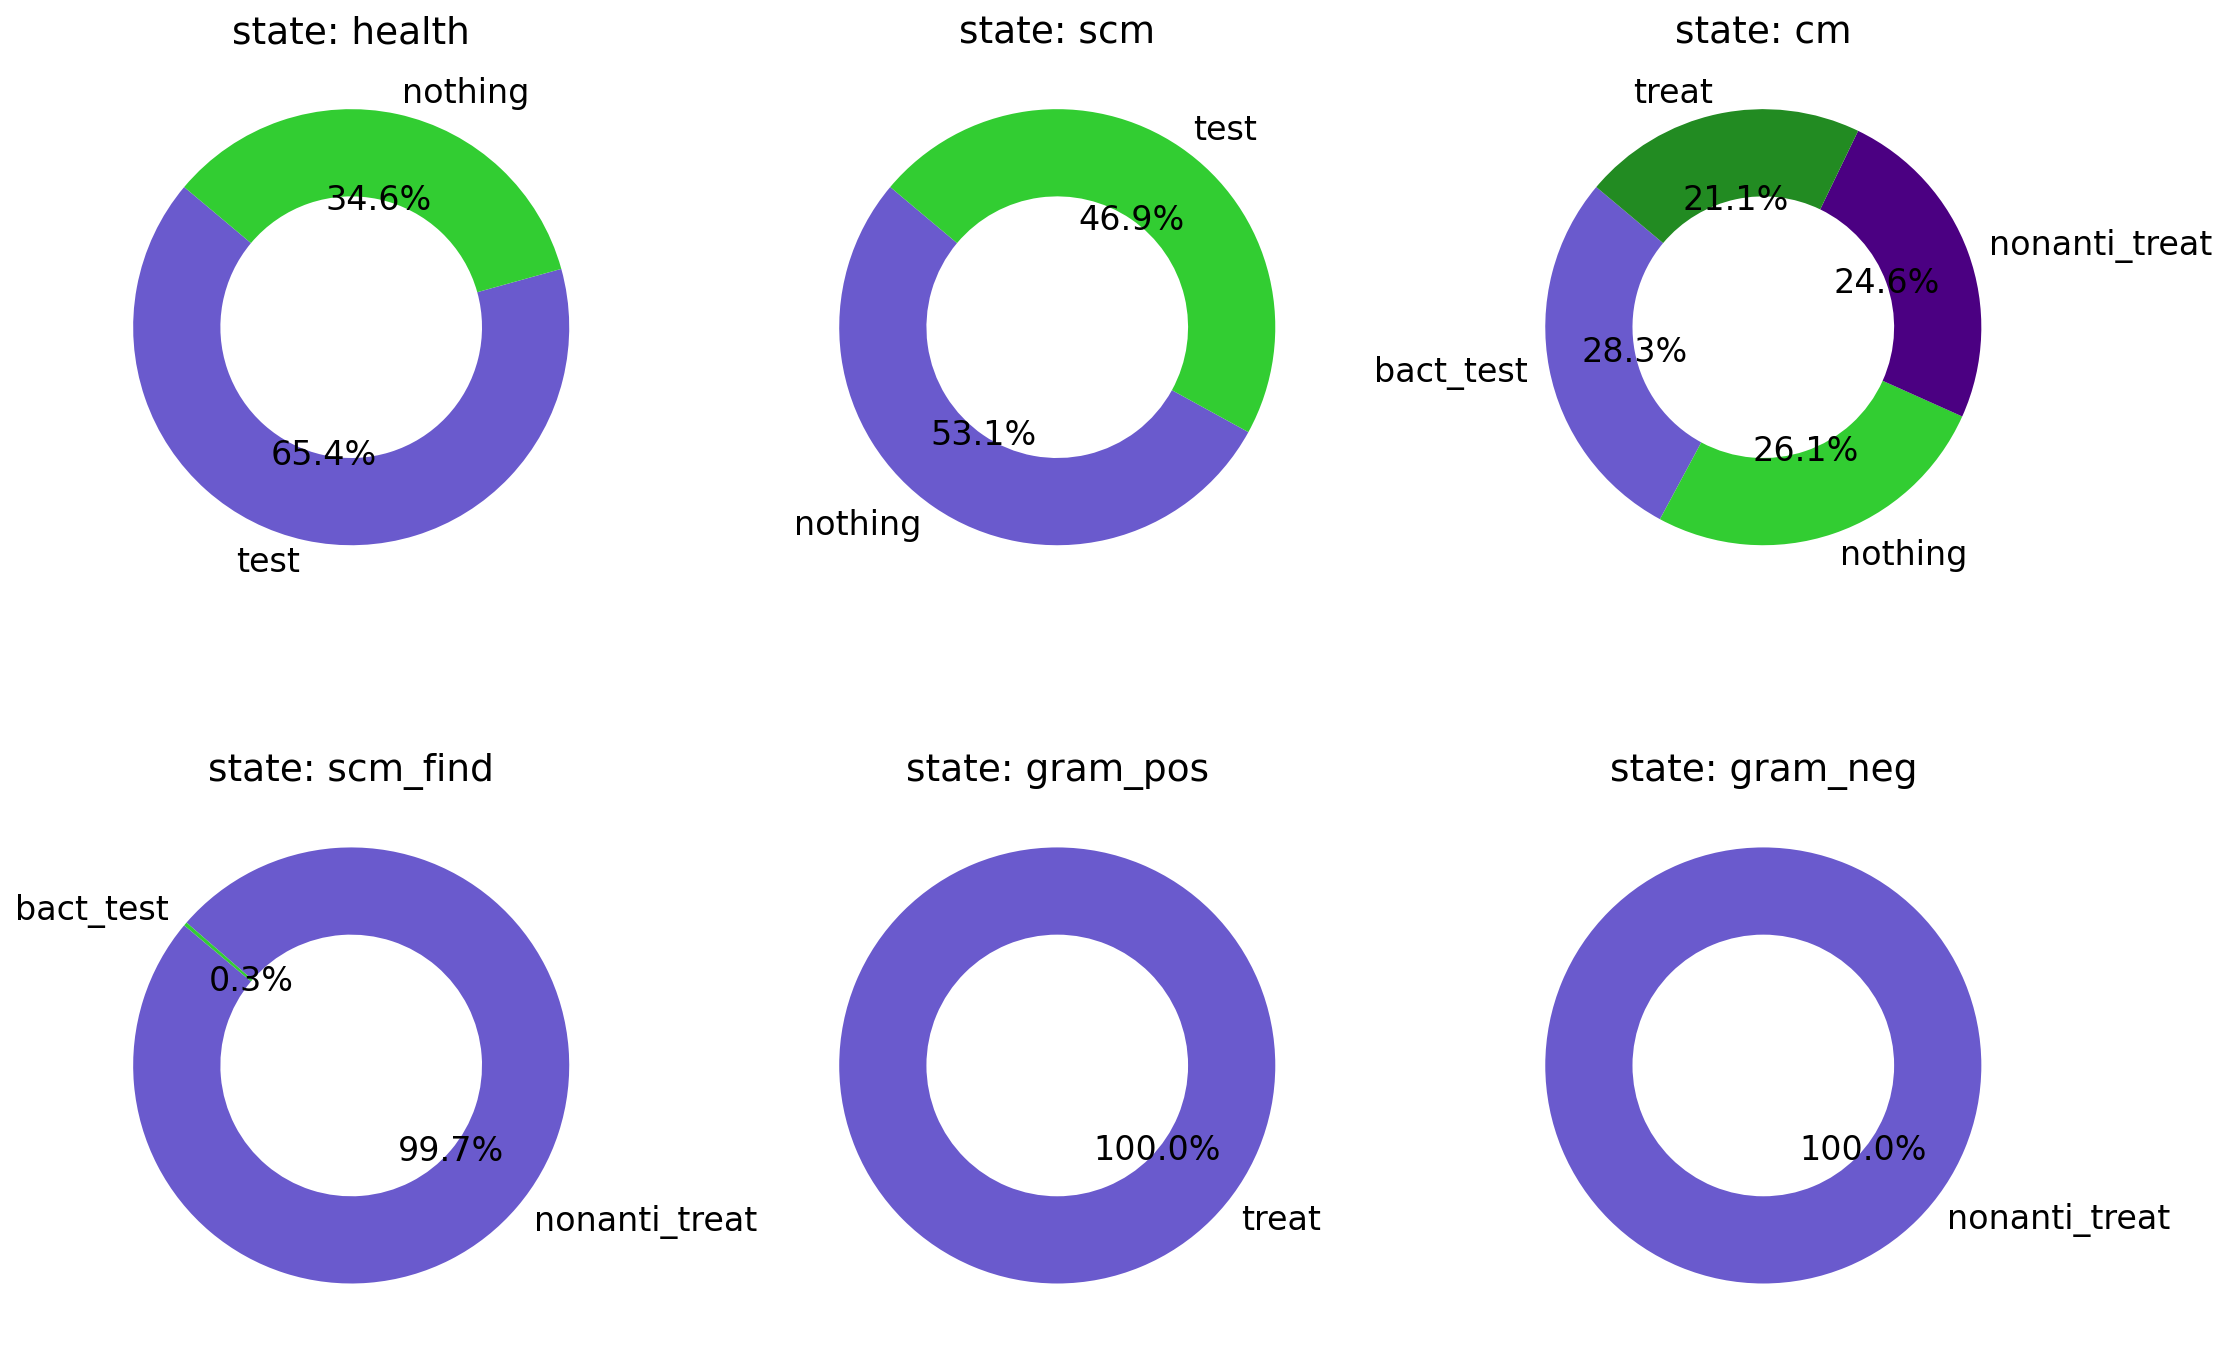

In [80]:
import matplotlib.pyplot as plt
"""
args: 
    ls_action: list[list[str]]
    ls_value: list[list[float]]
    states_ls: list[str]
    
"""
def plot_Q_learning_results(ls_action, ls_value, states_ls):
    # Create subplots in a 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

    # Flatten the array of axes for easier iteration
    axs = axs.flatten()

    # Plot each donut chart
    for i in range(6):
        actions = ls_action[i]
        values = ls_value[i]

        # Filter out non-zero actions and their values
        filtered_actions = [action for action, value in zip(actions, values) if value > 0]
        filtered_values = [value for value in values if value > 0]

        # Plot the donut chart
        wedges, texts, autotexts = axs[i].pie(
            filtered_values, 
            labels=filtered_actions, 
            autopct='%1.1f%%', 
            startangle=140, 
            wedgeprops={'width': 0.4},  # Make it a donut chart
            colors=['slateblue', 'limegreen', 'indigo', 'forestgreen', 'navy','green']
        )

        # Set larger text sizes for labels and percentages
        for text in texts:
            text.set_fontsize(16)  # Increase label font size
        for autotext in autotexts:
            autotext.set_fontsize(16)  # Increase percentage font size
        
        # Set the title for each subplot
        axs[i].set_title("state: "+ states_ls[i], fontsize=18)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

print("Inspect the optimal policy that Q-learning agent find: ")
#print("q-value: \n", agent.q) 
#print("states and actions: ", states_ls, actions_ls)

# init list to store results for ploting 
ls_action, ls_value = [], []
# loop and print best action for each states: 
for row in range(agent.q.shape[0]):
    print("for state: ", states_ls[row])
    # for each state rank the best action and print with value 
    sort_idx = np.argsort(agent.q[row])
    # sort action by sort idx 
    action_sort = [actions_ls[i] for i in sort_idx][::-1]
    ls_action.append(action_sort)
    print("action ranked: ", action_sort)
    print("value ranked: ", sorted(agent.q[row])[::-1])
    ls_value.append(sorted(agent.q[row])[::-1])
    print("\n-------------------------")
"""using func: """
plot_Q_learning_results(ls_action, ls_value, states_ls)